In [1]:
import folium
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

---
# Data Import
---

### Read the airlines data with all the flights from src to dest

In [2]:
airlines_data = pd.read_csv("data/airlines.csv")
airlines_data = airlines_data[["src_name", "src_id", "dest_name", "dest_id"]]
airlines_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   src_name   67663 non-null  object
 1   src_id     67663 non-null  object
 2   dest_name  67663 non-null  object
 3   dest_id    67663 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


### Read aiports data with corresponding latitude, longitude and altitude

In [3]:
airports_data = pd.read_csv("data/airports.csv")
airports_data = airports_data[["id", "name", "latitude", "longitude"]]
airports_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12668 entries, 0 to 12667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         12668 non-null  int64  
 1   name       12668 non-null  object 
 2   latitude   12668 non-null  float64
 3   longitude  12668 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 396.0+ KB


---
# Data Processing and Cleaning
---

### Fill the "\N" values of the airlines dataset and cast object columns to int64

In [4]:
name_to_id_mapping = pd.Series(airports_data["id"].values, index=airports_data["name"]).to_dict()
airlines_data.replace({"\\N": pd.NA}, inplace=True)
airlines_data["src_id"] = airlines_data["src_id"].fillna(airlines_data["src_name"].map(name_to_id_mapping))
airlines_data["dest_id"] = airlines_data["dest_id"].fillna(airlines_data["dest_name"].map(name_to_id_mapping))
airlines_data.dropna(inplace=True)
airlines_data["src_id"] = airlines_data["src_id"].astype(np.int64)
airlines_data["dest_id"] = airlines_data["dest_id"].astype(np.int64)
airlines_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67572 entries, 0 to 67662
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   src_name   67572 non-null  object
 1   src_id     67572 non-null  int64 
 2   dest_name  67572 non-null  object
 3   dest_id    67572 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ MB


### Merge the datasets and get the latitude and longitude for both source and destination airports

In [5]:
data = pd.merge(airlines_data, airports_data, left_on=["src_name"], right_on=["name"], how="left")
data = data.rename(columns={"latitude" : "src_latitude", "longitude": "src_longitude"})[["src_id", "src_name", "src_latitude", "src_longitude", "dest_id", "dest_name"]]
data = pd.merge(data, airports_data, left_on=["dest_name"], right_on=["name"], how="left")
data = data.rename(columns={"latitude" : "dest_latitude", "longitude": "dest_longitude"})[["src_id", "src_name", "src_latitude", "src_longitude", "dest_id", "dest_name", "dest_latitude", "dest_longitude"]]
data.dropna(inplace=True)
data

,src_id,src_name,src_latitude,src_longitude,dest_id,dest_name,dest_latitude,dest_longitude
0,2965,AER,43.449902,39.956600,2990,KZN,55.606201,49.278702
1,2966,ASF,46.283298,48.006302,2990,KZN,55.606201,49.278702
2,2966,ASF,46.283298,48.006302,2962,MRV,44.225101,43.081902
3,2968,CEK,55.305801,61.503300,2990,KZN,55.606201,49.278702
4,2968,CEK,55.305801,61.503300,4078,OVB,55.012600,82.650703
...,...,...,...,...,...,...,...,...
67567,6334,WYA,-33.058899,137.514008,3341,ADL,-34.945000,138.531006
67568,4029,DME,55.408798,37.906300,2912,FRU,43.061298,74.477600
67569,2912,FRU,43.061298,74.477600,4029,DME,55.408798,37.906300
67570,2912,FRU,43.061298,74.477600,2913,OSS,40.609001,72.793297


---
# Data Analysis (Part I)
---

### Counting the occurrences of each source name

In [6]:
src_count = data["src_name"].value_counts().reset_index()
src_count.columns = ["src_name", "count"]
src_count

,src_name,count
0,ATL,915
1,ORD,558
2,LHR,527
3,PEK,527
4,CDG,524
...,...,...
3351,OGS,1
3352,OLF,1
3353,YGZ,1
3354,PVC,1


### Counting the occurrences of each destination name

In [7]:
dest_count = data["dest_name"].value_counts().reset_index()
dest_count.columns = ["dest_name", "count"]
dest_count

,dest_name,count
0,ATL,911
1,ORD,550
2,PEK,527
3,LHR,524
4,CDG,517
...,...,...
3359,OER,1
3360,ESL,1
3361,OGL,1
3362,PES,1


---
# Visualization (Part I) - Total Dataset
---

In [8]:
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for _, route in data.iterrows():
    folium.PolyLine([(route["src_latitude"], route["src_longitude"]), (route["dest_latitude"], route["dest_longitude"])], color="cyan", weight=0.1, opacity=0.5).add_to(vis)
vis.save("vis1_total_dataset.html")

---
# Node Analysis (Part I)
---

### Build the Directed Graph
(Nodes represent airports and edges represent a route between two airports)

In [9]:
G = nx.DiGraph()

for _, row in data.iterrows():
    G.add_edge(row['src_name'], row['dest_name'], weight=1)

### Average Degree
(Calculate the in-degree and out-degree)
The average in-degree and out-degree are the same, this is actually an expected property of directed graphs, and it's based on the Handshaking Lemma. When we calculate the average in-degree and out-degree, we divide the total in-degree and out-degree by the number of nodes, respectively. Since the total in-degree and out-degree are equal (as per the lemma), their averages will also be equal. Thus, in any directed graph, the average in-degree is always equal to the average out-degree.

In [10]:
in_degrees = [deg for node, deg in G.in_degree()]
out_degrees = [deg for node, deg in G.out_degree()]

avg_in_degree = sum(in_degrees) / len(in_degrees)
avg_out_degree = sum(out_degrees) / len(out_degrees)

print(f"Average In-Degree: {avg_in_degree}")
print(f"Average Out-Degree: {avg_out_degree}")

Average In-Degree: 11.09012748295286
Average Out-Degree: 11.09012748295286


### Degree Rank
(Provides a visualization of the degrees of nodes within the network, ordered from the highest to the lowest. The x-axis represents the rank of each node (from the highest degree to the lowest), while the y-axis represents the degree of nodes. This plot is useful for quickly identifying the nodes with the highest degrees and observing the degree variability within the network. A steep curve indicates a few nodes have significantly higher degrees than the rest, which might suggest a scale-free network)

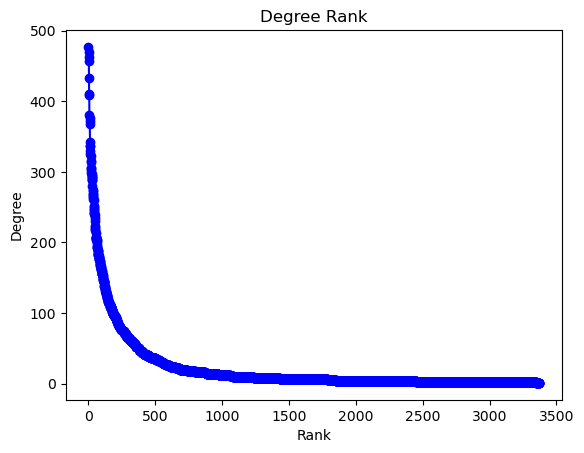

In [11]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.plot(degree_sequence, "b-", marker="o")
plt.title("Degree Rank")
plt.ylabel("Degree")
plt.xlabel("Rank")
plt.show()

### Degree Distribution
(Illustrates the distribution of node degrees across the entire network. The x-axis represents the degree k of nodes, and the y-axis represents the frequency or probability of nodes having degree k. This histogram provides insights into the commonality of nodes with certain degrees, enabling you to identify the most common and rare node degrees within the network. Peaks in the histogram indicate degrees that are more prevalent in the network)

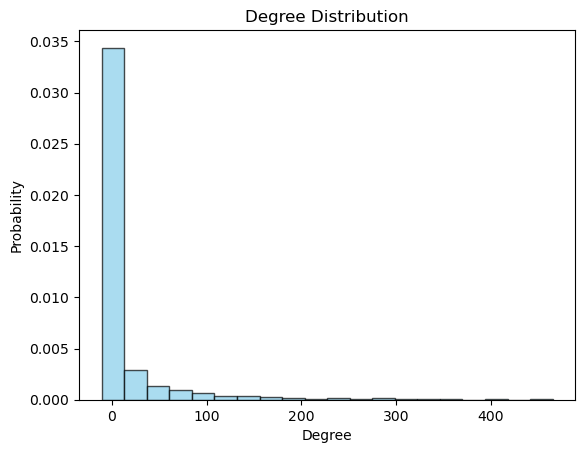

In [12]:
hist, bins = np.histogram(degree_sequence, bins=20, density=True)
plt.bar(bins[:-1], hist, width=np.diff(bins), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

### Log-Log Degree Rank
(It is a log-log plot of the degree distribution of the network. Both axes are on a logarithmic scale. The x-axis represents the degree k of nodes, and the y-axis represents the frequency or probability of nodes having degree k. This plot is particularly useful for identifying whether the degree distribution follows a power-law distribution, which is a common property of scale-free networks. A straight line on a log-log scale indicates a power-law distribution, while deviations from this can highlight interesting properties or anomalies in the network)

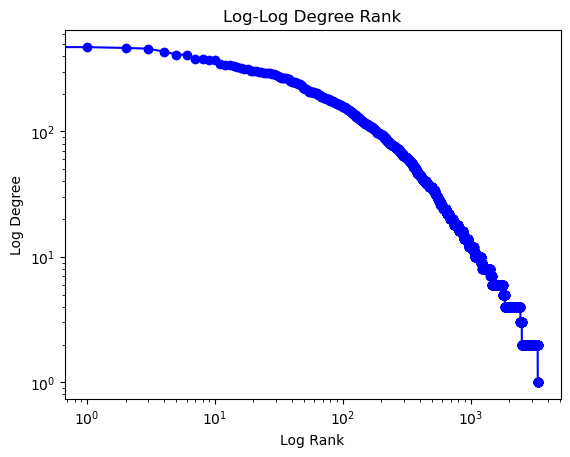

In [13]:
plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Log-Log Degree Rank")
plt.xlabel("Log Rank")
plt.ylabel("Log Degree")
plt.show()

### Cumulative Log-Log Degree Distribution
(It visualizes the cumulative degree distribution of the network on a log-log scale. The x-axis represents the degree k of nodes, and the y-axis represents the cumulative probability (≥) P(K≥k) that a node has a degree larger than or equal to k. This plot is especially useful for analyzing the tail behavior of the degree distribution, particularly in networks with heavy-tailed or power-law degree distributions. A smoother curve in the cumulative plot, as compared to the non-cumulative version, often provides a clearer visualization of the tail and can be more amenable to regression analysis for identifying power-law exponents)

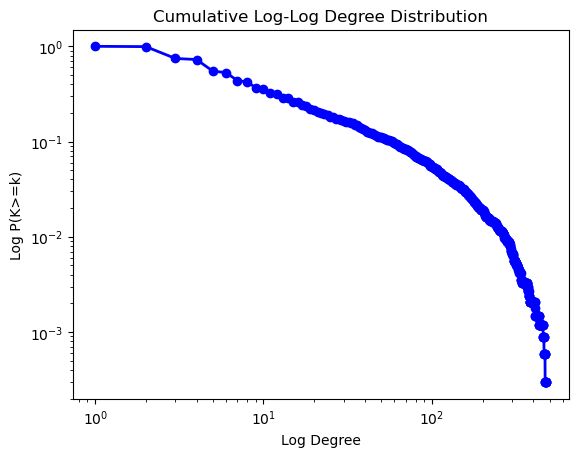

In [14]:
hist, bin_edges = np.histogram(degree_sequence, bins=np.arange(1, np.max(degree_sequence)+2), density=True)
cumulative_dist = np.cumsum(hist[::-1])[::-1]
plt.loglog(bin_edges[:-1], cumulative_dist, 'bo-', linewidth=2)
plt.title("Cumulative Log-Log Degree Distribution")
plt.xlabel("Log Degree")
plt.ylabel("Log P(K>=k)")
plt.show()

---
# Visualization (Part II) - Top 5 nodes with Highest Degree
---
(In this visualization, we will focus on the top 5 airports with the highest degree, omitting the visualization of all routes to enhance clarity and focus on these key hubs. Each airport will be represented by a marker, and the routes originating from these airports will be depicted by lines on the map. Different colors will be assigned to each airport and its respective routes for clear differentiation and analysis. This visualization will provide insights into the connectivity and network structure of the most central airports, which can be pivotal for strategic planning, route optimization, and understanding the flow and distribution of air traffic across the network)

In [15]:
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]
colors = ['red', 'blue', 'green', 'gray', 'orange']
vis = folium.Map(location=[0,0], zoom_start=3, tiles="cartodb dark_matter")
for idx, (node, _) in enumerate(top_nodes):
    lat = data[data['src_name'] == node]['src_latitude'].values[0]
    lon = data[data['src_name'] == node]['src_longitude'].values[0]
    folium.Marker(location=[lat, lon],
                  popup=f"{node}\nDegree: {degree_dict[node]}",
                  icon=folium.Icon(color=colors[idx])).add_to(vis)
    routes_from_node = data[data['src_name'] == node]
    for _, route in routes_from_node.iterrows():
        folium.PolyLine([(route["src_latitude"], route["src_longitude"]),
                         (route["dest_latitude"], route["dest_longitude"])],
                        color=colors[idx], weight=0.4, opacity=0.5).add_to(vis)
vis.save("vis2_top_nodes_by_degree.html")

### Average Path Degree
(Average of all vertex degrees in the network)

In [16]:
avg_degree = sum(degree_sequence) / len(degree_sequence)
print(f"Average Path Degree: {avg_degree}")

Average Path Degree: 22.18025496590572


### Average Path Length
(Average of all shortest paths in the network)

In [17]:
if nx.is_weakly_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    print(f"Average Path Length: {avg_path_length}")
else:
    print("The graph is not connected. Consider analyzing largest connected component.")

The graph is not connected. Consider analyzing largest connected component.


### Clustering Coefficient
(Measures the degree to which nodes in a graph tend to cluster together)

In [18]:
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering}")

Average Clustering Coefficient: 0.4716435526437847


Centrality Measures: Identify important nodes (airports) in the network.

Degree Centrality: Identify airports with the most direct routes.
Betweenness Centrality: Identify airports that act as significant transfer or stopover points.
Community Detection: Identify clusters or communities of airports that are more densely connected with each other than with other groups.

Assortativity: Measure the similarity of connections in the network with respect to the node degree.

Network Resilience: Analyze how the network structure is affected by the removal of nodes or edges, which could simulate disruptions in the airline network.


Top Nodes by Degree:
Description: Visualizing the top nodes (airports) with the highest degree on the map can provide insights into major airline hubs and busiest airports.
Visualization: You might represent these nodes with larger or differently colored markers to highlight them on the map.
2. High Traffic Routes:
Description: Highlighting the routes (edges) that have the highest traffic or frequency can illustrate the main airline corridors.
Visualization: You might use thicker or differently colored lines to represent these high-traffic routes on the map.
3. Geographical Clusters:
Description: Identifying and visualizing clusters of nodes that are tightly connected can reveal regional airline networks.
Visualization: You might use different colors for nodes and edges that belong to different clusters.
4. Centrality Measures:
Description: Nodes with high centrality measures (like betweenness centrality) can be crucial for the connectivity of the network.
Visualization: Highlighting these nodes can reveal airports that, while not necessarily having the highest degree, play a crucial role in connecting different parts of the network.
5. Community Structures:
Description: Visualizing community structures can reveal groups of nodes that are more densely connected with each other than with the rest of the network.
Visualization: Different communities might be visualized using different colors or shapes for nodes and edges.
6. Disconnected Components:
Description: Identifying and visualizing disconnected components of the network can reveal isolated sub-networks within the airline routes.
Visualization: Different components might be visualized using different colors.
7. Shortest Paths:
Description: Visualizing the shortest paths between selected major airports might provide insights into the efficiency and connectivity of the network.
Visualization: Highlighting the shortest path routes with distinct line styles or colors.
8. Vulnerability Analysis:
Description: Identifying and visualizing nodes whose removal would significantly disrupt the network can highlight vulnerabilities in the airline route network.
Visualization: Such nodes might be visualized with specific markers or colors.